## Collatz beta notebook

In [1]:
"""
This notebook analyses the betas of collatz sequences and their relationship
to other components. The beta  of an odd collatz number is defined by the 
following equation: beta = 1 + 1/k*x where x is the odd number. 
"""

# Fix possible import problems
import sys
sys.path.append("..")

# Imports
import random as rnd
import matplotlib.pyplot as plt
from math import log2
import pandas as pd
from collatz import commons as com
from collatz import generator as gen
from collatz import cycles


# Helper functions
def _predict_alpha(k_factor, cycle_lengths):
    result_list = []
    for i in cycle_lengths:
        result_list.append(cycles.predict_cycle_alpha(k_factor, i))
    return result_list


# Configuration
k = 3
max_value = 1001
max_iterations = 500
start_value = rnd.randint(1, max_value)

if start_value % 2 == 0:
    start_value = start_value + 1

pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_rows', 10000)
pd.set_option('display.expand_frame_repr', False)

# Create a collatz sequence and analyse it
analysis_frame = gen.generate_odd_collatz_sequence(
    start_value=start_value, k=k, max_iterations=max_iterations)

# Filter odd values
analysis_frame = analysis_frame[analysis_frame["odd"] == 1]
analysis_frame = analysis_frame.reset_index(drop=True)

# Derive additional fields
analysis_frame["i"] = analysis_frame.index + 1
analysis_frame["log_k^i"] = log2(k)*analysis_frame["i"]

# Calculate alpha
analysis_frame["alpha"] = analysis_frame["next_collatz"].apply(com.trailing_zeros)
analysis_frame["alpha"] = analysis_frame["alpha"].astype("int64")
analysis_frame["alpha_sum"] = analysis_frame["alpha"].cumsum()
analysis_frame["alpha_pred"] = _predict_alpha(k, analysis_frame['i'])
analysis_frame["alpha_diff"] = analysis_frame["alpha_pred"] - analysis_frame["alpha_sum"]
analysis_frame["next_alpha_pred"] = _predict_alpha(k, analysis_frame['i'])

# Calculate beta
analysis_frame["beta"] = 1 + 1/(k*analysis_frame["collatz"])
analysis_frame["beta_prod"] = analysis_frame["beta"].cumprod()
analysis_frame["beta_log"] = analysis_frame["beta"].apply(log2)
analysis_frame["beta_prod_log"] = analysis_frame["beta_prod"].apply(log2)

analysis_frame["beta_prod_hyp"] = \
    analysis_frame["alpha_pred"] - analysis_frame["log_k^i"]  \
    + analysis_frame["alpha_diff"]

analysis_frame["beta_prod_diff"] = \
    analysis_frame["beta_prod_hyp"] - analysis_frame["beta_prod_log"]
analysis_frame["beta_prod_diff"] = analysis_frame["beta_prod_diff"].round(4)

# Get max and min values
max_beta_prod_log = round(analysis_frame["beta_prod_log"].max(), 4)
beta_diff =  analysis_frame[analysis_frame["beta_prod_diff"] >= 0]["beta_prod_diff"]
min_beta_diff = None
min_i = None

if len(beta_diff) > 0:
    min_beta_diff = beta_diff.min()
    min_i = beta_diff.idxmin() + 1

# Print results
print_frame = analysis_frame[[
    "i", "collatz", "log_k^i", "alpha_sum", "alpha_pred", "alpha_diff",
    "beta_prod_log", "beta_prod_hyp", "beta_prod_diff"]]

print_frame.columns = ["i","xi", "k^i", "a", "a_pred", "a_diff",
                       "b_prod", "b_prod_hyp", "b_prod_diff"]

print("x1:", start_value, " K:", k, 
      " Max(b_prod):", max_beta_prod_log, 
      " Min(b_prod_diff):", min_beta_diff,
      " i:", min_i,
      "\n")

print(print_frame.to_string(index=False), "\n")

x1: 339  K: 3  Max(b_prod): 0.6505  Min(b_prod_diff): 0.2402  i: 3 

  i    xi        k^i   a  a_pred  a_diff    b_prod  b_prod_hyp  b_prod_diff
  1   339   1.584963   1       2       1  0.001418    1.415037       1.4136
  2   509   3.169925   4       4       0  0.002362    0.830075       0.8277
  3   191   4.754888   5       5       0  0.004878    0.245112       0.2402
  4   287   6.339850   6       7       1  0.006553    1.660150       1.6536
  5   431   7.924813   7       8       1  0.007668    1.075187       1.0675
  6   647   9.509775   8      10       2  0.008411    2.490225       2.4818
  7   971  11.094738   9      12       3  0.008906    3.905262       3.8964
  8  1457  12.679700  11      13       2  0.009236    2.320300       2.3111
  9  1093  14.264663  15      15       0  0.009676    0.735337       0.7257
 10   205  15.849625  18      16      -2  0.012020   -1.849625      -1.8616
 11    77  17.434588  21      18      -3  0.018252   -2.434588      -2.4528
 12    29  19.01955

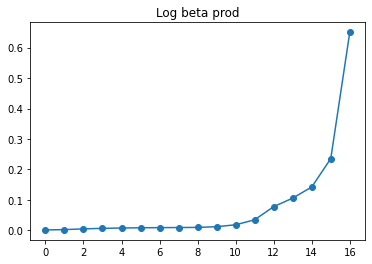

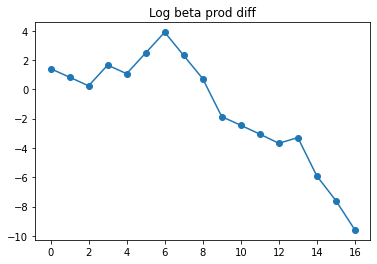

In [2]:
# Plot results
plt.figure()
plt.title("Log beta prod")
plt.plot(analysis_frame["beta_prod_log"], "-o", label='log beta prod')

plt.figure()
plt.title("Log beta prod diff")
plt.plot(analysis_frame["beta_prod_diff"], "-o", label='diff')

plt.show()